In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
import pydotplus
from IPython.display import Image
from six import StringIO

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.metrics import confusion_matrix

import config

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [2]:
df=pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR+'/data_metabric_table_1.2.pkl')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT_ID                           2509 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE        2243 non-null   float64
 2   NPI                                  2287 non-null   float64
 3   COHORT                               2509 non-null   object 
 4   SEX                                  2509 non-null   object 
 5   INTCLUST                             2509 non-null   object 
 6   AGE_AT_DIAGNOSIS                     2498 non-null   float64
 7   OS_MONTHS                            1981 non-null   float64
 8   OS_STATUS                            2509 non-null   bool   
 9   CLAUDIN_SUBTYPE                      2509 non-null   object 
 10  THREEGENE                            2509 non-null   object 
 11  VITAL_STATUS                  

In [22]:
df.head()

,PATIENT_ID,LYMPH_NODES_EXAMINED_POSITIVE,NPI,COHORT,SEX,INTCLUST,AGE_AT_DIAGNOSIS,OS_MONTHS,OS_STATUS,CLAUDIN_SUBTYPE,THREEGENE,VITAL_STATUS,LATERALITY,HISTOLOGICAL_SUBTYPE,BREAST_SURGERY,RFS_STATUS,RFS_MONTHS,CELLULARITY_converted,ER_IHC_converted,HER2_SNP6_converted,INFERRED_MENOPAUSAL_STATE_converted,CHEMOTHERAPY_converted,HORMONE_THERAPY_converted,RADIO_THERAPY_converted,PATIENT_ID,SAMPLE_ID,CANCER_TYPE,CANCER_TYPE_DETAILED,GRADE,ONCOTREE_CODE,SAMPLE_TYPE,TUMOR_SIZE,TUMOR_STAGE,TMB_NONSYNONYMOUS,ER_STATUS_converted,HER2_STATUS_converted,PR_STATUS_converted
1,MB-0002,0.0,4.020,1.0,Female,4ER+,43.19,84.633333,False,LumA,ER+/HER2- High Prolif,Living,Right,Ductal/NST,BREAST CONSERVING,False,83.52,3.0,1.0,2.0,-1.0,False,True,True,MB-0002,MB-0002,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,10.0,1.0,2.615035,1.0,-1.0,1.0
4,MB-0008,8.0,6.080,1.0,Female,9,76.97,41.366667,True,LumB,ER+/HER2- High Prolif,Died of Disease,Right,Mixed,MASTECTOMY,True,18.55,3.0,1.0,2.0,1.0,True,True,True,MB-0008,MB-0008,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,3.0,MDLC,Primary,40.0,2.0,2.615035,1.0,-1.0,1.0
5,MB-0010,0.0,4.062,1.0,Female,7,78.77,7.800000,True,LumB,ER+/HER2- High Prolif,Died of Disease,Left,Ductal/NST,MASTECTOMY,True,2.89,2.0,1.0,2.0,1.0,False,True,True,MB-0010,MB-0010,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,31.0,4.0,5.230071,1.0,-1.0,1.0
10,MB-0028,1.0,5.032,1.0,Female,9,86.41,36.566667,True,LumB,ER+/HER2- High Prolif,Died of Other Causes,Right,Ductal/NST,BREAST CONSERVING,False,36.09,2.0,1.0,3.0,1.0,False,True,True,MB-0028,MB-0028,Breast Cancer,Breast Invasive Ductal Carcinoma,3.0,IDC,Primary,16.0,2.0,5.230071,1.0,-1.0,-1.0
11,MB-0035,0.0,3.056,1.0,Female,3,84.22,36.266667,True,Her2,ER+/HER2- High Prolif,Died of Disease,Left,Lobular,MASTECTOMY,True,35.79,3.0,-1.0,1.0,1.0,False,False,False,MB-0035,MB-0035,Breast Cancer,Breast Invasive Lobular Carcinoma,2.0,ILC,Primary,28.0,2.0,6.537589,1.0,-1.0,-1.0


In [3]:
target_columns=[
    # patient
    'OS_MONTHS',
    'RFS_MONTHS',
    'OS_STATUS',
    'RFS_STATUS',
    'VITAL_STATUS',
]

int_columns=[
    # patient
    'LYMPH_NODES_EXAMINED_POSITIVE',
    
    'OS_MONTHS',
    'RFS_MONTHS',
]

float_columns=[
    # patient
    'NPI',
    'AGE_AT_DIAGNOSIS',
    # sample
    'TUMOR_SIZE',
    'TMB_NONSYNONYMOUS',
]

str_columns=[
]

# 質的変数（順序尺度）
qualitative_ordinal_columns=[
    # patient
    'CELLULARITY_converted',  
    'ER_IHC_converted',
    'HER2_SNP6_converted',
    'INFERRED_MENOPAUSAL_STATE_converted',
    # sample
    'ER_STATUS_converted',
    'HER2_STATUS_converted',
    'GRADE',
    'PR_STATUS_converted',
    'TUMOR_STAGE',
]
# 質的変数（名義尺度）
qualitative_name_columns=[
    # patient
    'COHORT',
    'INTCLUST',
    'CLAUDIN_SUBTYPE',
    'THREEGENE',
    'HISTOLOGICAL_SUBTYPE',
    'BREAST_SURGERY',
    'LATERALITY',
    
    'VITAL_STATUS',
    # sample
    'CANCER_TYPE',
    'CANCER_TYPE_DETAILED',
    'ONCOTREE_CODE',

]

bool_columns=[
    # patient
    'CHEMOTHERAPY_converted',
    'HORMONE_THERAPY_converted',
    'RADIO_THERAPY_converted',
]

meanless_columns=[
    # patient
    'PATIENT_ID',
    'SEX',
    
    'OS_STATUS',
    'RFS_STATUS',
    # sample
    'PATIENT_ID',
    'SAMPLE_ID',
    'SAMPLE_TYPE',
]

print(df.shape[1],
    len(int_columns)+\
    len(float_columns)+\
    len(ｓｔｒ_columns)+\
    len(qualitative_ordinal_columns)+\
    len(qualitative_name_columns)+\
    len(bool_columns)+\
    len(meanless_columns))
assert  df.shape[1]==\
    len(int_columns)+\
    len(float_columns)+\
    len(ｓｔｒ_columns)+\
    len(qualitative_ordinal_columns)+\
    len(qualitative_name_columns)+\
    len(bool_columns)+\
    len(meanless_columns), 'lack or too much columns'

37 37


### drop na data

In [4]:
df.dropna(how='any', inplace=True)
for i in qualitative_name_columns:
    df=df[df[i]!='nan'].copy()
    df[i].value_counts()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 1 to 1743
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT_ID                           1124 non-null   object 
 1   LYMPH_NODES_EXAMINED_POSITIVE        1124 non-null   float64
 2   NPI                                  1124 non-null   float64
 3   COHORT                               1124 non-null   object 
 4   SEX                                  1124 non-null   object 
 5   INTCLUST                             1124 non-null   object 
 6   AGE_AT_DIAGNOSIS                     1124 non-null   float64
 7   OS_MONTHS                            1124 non-null   float64
 8   OS_STATUS                            1124 non-null   bool   
 9   CLAUDIN_SUBTYPE                      1124 non-null   object 
 10  THREEGENE                            1124 non-null   object 
 11  VITAL_STATUS                  

## create target column

目的変数：5年以内の死亡判定→5年以内のデータは除外する

In [5]:
df['VITAL_STATUS'].value_counts()

Living                  504
Died of Disease         378
Died of Other Causes    242
Name: VITAL_STATUS, dtype: int64

In [12]:
# df[(df['OS_MONTHS']>=60) & ((df['VITAL_STATUS']=='Living')|(df['VITAL_STATUS']=='Died of Other Causes'))].shape

In [13]:
df[(df['OS_MONTHS']<=60) & (df['VITAL_STATUS']=='Died of Disease')].shape

(198, 37)

### 目的変数の生成

VITAL_STATUSとOS_MONTHSから目的変数を生成する

In [34]:
df_enough_months=df.copy()

df_enough_months['IN_5YEARS_STATUS']=np.nan
# dead in 5years=True
df_enough_months['IN_5YEARS_STATUS']=df_enough_months['IN_5YEARS_STATUS'].mask((df_enough_months['OS_MONTHS']<=60) &
                                          (df_enough_months['VITAL_STATUS']=='Died of Disease'), True)
df_enough_months['IN_5YEARS_STATUS']=df_enough_months['IN_5YEARS_STATUS'].mask((df_enough_months['OS_MONTHS']>=60) &
                                          (df_enough_months['VITAL_STATUS']=='Living')|
                                          (df_enough_months['VITAL_STATUS']=='Died of Other Causes') , False)
df_enough_months.dropna(inplace=True)
df_enough_months.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 908 entries, 1 to 1743
Data columns (total 38 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PATIENT_ID                           908 non-null    object 
 1   LYMPH_NODES_EXAMINED_POSITIVE        908 non-null    float64
 2   NPI                                  908 non-null    float64
 3   COHORT                               908 non-null    object 
 4   SEX                                  908 non-null    object 
 5   INTCLUST                             908 non-null    object 
 6   AGE_AT_DIAGNOSIS                     908 non-null    float64
 7   OS_MONTHS                            908 non-null    float64
 8   OS_STATUS                            908 non-null    bool   
 9   CLAUDIN_SUBTYPE                      908 non-null    object 
 10  THREEGENE                            908 non-null    object 
 11  VITAL_STATUS                   

In [35]:
df_enough_months['IN_5YEARS_STATUS'].value_counts()

False    710
True     198
Name: IN_5YEARS_STATUS, dtype: int64

In [36]:
df_enough_months['IN_5YEARS_STATUS']=df_enough_months['IN_5YEARS_STATUS'].astype(bool)
df_enough_months.dtypes

PATIENT_ID                              object
LYMPH_NODES_EXAMINED_POSITIVE          float64
NPI                                    float64
COHORT                                  object
SEX                                     object
INTCLUST                                object
AGE_AT_DIAGNOSIS                       float64
OS_MONTHS                              float64
OS_STATUS                                 bool
CLAUDIN_SUBTYPE                         object
THREEGENE                               object
VITAL_STATUS                            object
LATERALITY                              object
HISTOLOGICAL_SUBTYPE                    object
BREAST_SURGERY                          object
RFS_STATUS                                bool
RFS_MONTHS                             float64
CELLULARITY_converted                  float64
ER_IHC_converted                       float64
HER2_SNP6_converted                    float64
INFERRED_MENOPAUSAL_STATE_converted    float64
CHEMOTHERAPY_

### drop columns
targetを作成したので、リークになりうるcolumnsは削除 

In [37]:
def create_drop_columne(target:str, target_columns:list=target_columns, meanless_columns:list=meanless_columns,):
    drop_columns=[i for i in target_columns if i not in [target]]+meanless_columns
    return drop_columns

In [38]:
target='IN_5YEARS_STATUS'
drop_columns=create_drop_columne(target)
df_droped=df_enough_months.drop(drop_columns, axis=1).copy()
df_enough_months.shape, df_droped.shape

((908, 38), (908, 28))

In [39]:
df_droped.columns

Index(['LYMPH_NODES_EXAMINED_POSITIVE', 'NPI', 'COHORT', 'INTCLUST',
       'AGE_AT_DIAGNOSIS', 'CLAUDIN_SUBTYPE', 'THREEGENE', 'LATERALITY',
       'HISTOLOGICAL_SUBTYPE', 'BREAST_SURGERY', 'CELLULARITY_converted',
       'ER_IHC_converted', 'HER2_SNP6_converted',
       'INFERRED_MENOPAUSAL_STATE_converted', 'CHEMOTHERAPY_converted',
       'HORMONE_THERAPY_converted', 'RADIO_THERAPY_converted', 'CANCER_TYPE',
       'CANCER_TYPE_DETAILED', 'GRADE', 'ONCOTREE_CODE', 'TUMOR_SIZE',
       'TUMOR_STAGE', 'TMB_NONSYNONYMOUS', 'ER_STATUS_converted',
       'HER2_STATUS_converted', 'PR_STATUS_converted', 'IN_5YEARS_STATUS'],
      dtype='object')

### onehot encoding
決定木に入れるためにobject型をonehotエンコーディング(nullは削除する)

In [40]:
qualitative_name_columns.remove('VITAL_STATUS') if 'VITAL_STATUS' in  qualitative_name_columns else qualitative_name_columns
qualitative_name_columns

['COHORT',
 'INTCLUST',
 'CLAUDIN_SUBTYPE',
 'THREEGENE',
 'HISTOLOGICAL_SUBTYPE',
 'BREAST_SURGERY',
 'LATERALITY',
 'CANCER_TYPE',
 'CANCER_TYPE_DETAILED',
 'ONCOTREE_CODE']

In [41]:
onehot_encoder=OneHotEncoder()
onehot_encoding_columns=qualitative_name_columns
onehot_encoder.fit(df_droped[onehot_encoding_columns])
display(onehot_encoder.categories_)
display(onehot_encoder.get_feature_names_out(onehot_encoding_columns))
#enc.transform(df[encoding_columns]).toarray()
df_onehot=pd.DataFrame(onehot_encoder.transform(df_droped[onehot_encoding_columns]).toarray(), 
             columns=onehot_encoder.get_feature_names_out(onehot_encoding_columns))


[array(['1.0', '2.0', '3.0', '5.0'], dtype=object),
 array(['1', '10', '2', '3', '4ER+', '4ER-', '5', '6', '7', '8', '9'],
       dtype=object),
 array(['Basal', 'Her2', 'LumA', 'LumB', 'NC', 'Normal', 'claudin-low'],
       dtype=object),
 array(['ER+/HER2- High Prolif', 'ER+/HER2- Low Prolif', 'ER-/HER2-',
        'HER2+'], dtype=object),
 array(['Ductal/NST', 'Lobular', 'Medullary', 'Mixed', 'Mucinous', 'Other',
        'Tubular/ cribriform'], dtype=object),
 array(['BREAST CONSERVING', 'MASTECTOMY'], dtype=object),
 array(['Left', 'Right'], dtype=object),
 array(['Breast Cancer'], dtype=object),
 array(['Breast', 'Breast Invasive Ductal Carcinoma',
        'Breast Invasive Lobular Carcinoma',
        'Breast Invasive Mixed Mucinous Carcinoma',
        'Breast Mixed Ductal and Lobular Carcinoma'], dtype=object),
 array(['BREAST', 'IDC', 'ILC', 'IMMC', 'MDLC'], dtype=object)]

array(['COHORT_1.0', 'COHORT_2.0', 'COHORT_3.0', 'COHORT_5.0',
       'INTCLUST_1', 'INTCLUST_10', 'INTCLUST_2', 'INTCLUST_3',
       'INTCLUST_4ER+', 'INTCLUST_4ER-', 'INTCLUST_5', 'INTCLUST_6',
       'INTCLUST_7', 'INTCLUST_8', 'INTCLUST_9', 'CLAUDIN_SUBTYPE_Basal',
       'CLAUDIN_SUBTYPE_Her2', 'CLAUDIN_SUBTYPE_LumA',
       'CLAUDIN_SUBTYPE_LumB', 'CLAUDIN_SUBTYPE_NC',
       'CLAUDIN_SUBTYPE_Normal', 'CLAUDIN_SUBTYPE_claudin-low',
       'THREEGENE_ER+/HER2- High Prolif',
       'THREEGENE_ER+/HER2- Low Prolif', 'THREEGENE_ER-/HER2-',
       'THREEGENE_HER2+', 'HISTOLOGICAL_SUBTYPE_Ductal/NST',
       'HISTOLOGICAL_SUBTYPE_Lobular', 'HISTOLOGICAL_SUBTYPE_Medullary',
       'HISTOLOGICAL_SUBTYPE_Mixed', 'HISTOLOGICAL_SUBTYPE_Mucinous',
       'HISTOLOGICAL_SUBTYPE_Other',
       'HISTOLOGICAL_SUBTYPE_Tubular/ cribriform',
       'BREAST_SURGERY_BREAST CONSERVING', 'BREAST_SURGERY_MASTECTOMY',
       'LATERALITY_Left', 'LATERALITY_Right', 'CANCER_TYPE_Breast Cancer',
       'CANCE

In [42]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 48 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   COHORT_1.0                                                      908 non-null    float64
 1   COHORT_2.0                                                      908 non-null    float64
 2   COHORT_3.0                                                      908 non-null    float64
 3   COHORT_5.0                                                      908 non-null    float64
 4   INTCLUST_1                                                      908 non-null    float64
 5   INTCLUST_10                                                     908 non-null    float64
 6   INTCLUST_2                                                      908 non-null    float64
 7   INTCLUST_3                                           

In [43]:
df_encoded=pd.merge(df_droped.reset_index(drop=True), df_onehot.reset_index(drop=True), 
                    left_index=True, right_index=True).drop(onehot_encoding_columns, axis=1)
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 66 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   908 non-null    float64
 1   NPI                                                             908 non-null    float64
 2   AGE_AT_DIAGNOSIS                                                908 non-null    float64
 3   CELLULARITY_converted                                           908 non-null    float64
 4   ER_IHC_converted                                                908 non-null    float64
 5   HER2_SNP6_converted                                             908 non-null    float64
 6   INFERRED_MENOPAUSAL_STATE_converted                             908 non-null    float64
 7   CHEMOTHERAPY_converted                               

# 学習モデル作成

学習用にデータを分割

In [44]:
y=df_encoded[target]
X=df_encoded.drop(target, axis=1)

In [45]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 908 entries, 0 to 907
Series name: IN_5YEARS_STATUS
Non-Null Count  Dtype
--------------  -----
908 non-null    bool 
dtypes: bool(1)
memory usage: 1.0 KB


In [46]:
y.value_counts()

False    710
True     198
Name: IN_5YEARS_STATUS, dtype: int64

In [47]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 908 entries, 0 to 907
Data columns (total 65 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   LYMPH_NODES_EXAMINED_POSITIVE                                   908 non-null    float64
 1   NPI                                                             908 non-null    float64
 2   AGE_AT_DIAGNOSIS                                                908 non-null    float64
 3   CELLULARITY_converted                                           908 non-null    float64
 4   ER_IHC_converted                                                908 non-null    float64
 5   HER2_SNP6_converted                                             908 non-null    float64
 6   INFERRED_MENOPAUSAL_STATE_converted                             908 non-null    float64
 7   CHEMOTHERAPY_converted                               

In [48]:
X_train, X_test, y_train, y_test=train_test_split(X,y, train_size=0.7, random_state=1)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
display(y_train.value_counts(), y_test.value_counts())

(635, 65)

(273, 65)

(635,)

(273,)

False    488
True     147
Name: IN_5YEARS_STATUS, dtype: int64

False    222
True      51
Name: IN_5YEARS_STATUS, dtype: int64

In [49]:
accuracies={}

for nodes in range(2,50):
    clf = DecisionTreeClassifier(max_leaf_nodes=nodes)
    clf = clf.fit(X_train, y_train)
    #print(clf.classes_)

    y_pred=clf.predict(X_test)
    # accuracy
    
    accuracy=sum(y_test==y_pred)/y_test.shape[0]
    accuracies[nodes]=accuracy
    print('nodes: ',nodes, 'accuracy: ', accuracy)

nodes:  2 accuracy:  0.7838827838827839
nodes:  3 accuracy:  0.7838827838827839
nodes:  4 accuracy:  0.7912087912087912
nodes:  5 accuracy:  0.7912087912087912
nodes:  6 accuracy:  0.7875457875457875
nodes:  7 accuracy:  0.7838827838827839
nodes:  8 accuracy:  0.7802197802197802
nodes:  9 accuracy:  0.7802197802197802
nodes:  10 accuracy:  0.7802197802197802
nodes:  11 accuracy:  0.7838827838827839
nodes:  12 accuracy:  0.7838827838827839
nodes:  13 accuracy:  0.7838827838827839
nodes:  14 accuracy:  0.7838827838827839
nodes:  15 accuracy:  0.7838827838827839
nodes:  16 accuracy:  0.7765567765567766
nodes:  17 accuracy:  0.7948717948717948
nodes:  18 accuracy:  0.7948717948717948
nodes:  19 accuracy:  0.7802197802197802
nodes:  20 accuracy:  0.7948717948717948
nodes:  21 accuracy:  0.7948717948717948
nodes:  22 accuracy:  0.7838827838827839
nodes:  23 accuracy:  0.7912087912087912
nodes:  24 accuracy:  0.7802197802197802
nodes:  25 accuracy:  0.7802197802197802
nodes:  26 accuracy:  0.

In [50]:
max(accuracies, key=accuracies.get)

17

最も精度のよいleaf_nodesのパラメーターで再度モデル構築

In [51]:
clf = DecisionTreeClassifier(max_leaf_nodes=max(accuracies, key=accuracies.get))
clf = clf.fit(X_train, y_train)
#print(clf.classes_)

y_pred=clf.predict(X_test)
# accuracy

print(sum(y_test==y_pred)/y_test.shape[0])

0.7912087912087912


In [52]:
y.unique()

array([False,  True])

In [53]:
dot_data = StringIO() #dotファイル情報の格納先
export_graphviz(clf, out_file=dot_data,  
                     feature_names=X.columns,
                     #class_names= y.unique(),
                     filled=True, rounded=True,  
                     special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())
graph.write_png(config.TREE_DIR+'/2.0-decision_tree_model.png')

True

In [54]:
y_test.value_counts()[0]

222

In [55]:
display(y_test.value_counts())

display('baseline:', y_test.value_counts()/y_test.size)

False    222
True      51
Name: IN_5YEARS_STATUS, dtype: int64

'baseline:'

False    0.813187
True     0.186813
Name: IN_5YEARS_STATUS, dtype: float64

In [56]:
y_pred=clf.predict(X_test)
# accuracy
sum(y_test==y_pred)/y_test.shape[0]

0.7912087912087912

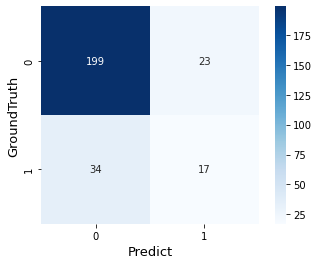

In [57]:
cm=confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, cbar=True, annot=True, cmap='Blues', fmt='1.0f')
plt.xlabel("Predict", fontsize=13)
plt.ylabel("GroundTruth", fontsize=13)
plt.savefig(config.TREE_DIR+'/2.0-decision_tree_confusion-matrix.png')